## Predict future revenue Growth Rate

In [1]:
# import libraries
import pandas as pd
import os
import numpy as np

from sklearn.preprocessing import StandardScaler

import pickle

In [2]:
# create directory to store tuning results
output_relative_dirs = ['../models/growth_standardiser/sum_transactions', '../models/growth_standardiser/number_of_customers', 
    '../models/growth_standardiser/distinct_customers']

# check if it exists as it makedir will raise an error if it does exist
for output_relative_dir in output_relative_dirs:
    if not os.path.exists(output_relative_dir):
        os.makedirs(output_relative_dir)

In [3]:
# read data
growth = pd.read_csv("../data/curated/growth_variable/merchant_fortnight_w_pctchange_train.csv")
growth = growth.drop(['E(r)', 'n_customers_pctchange', 'n_distinct_customers_pctchange'], axis=1)

In [4]:
# # first divide into train val split (so we don't overfit when doing standardisation)
# train = growth[(growth['Year'] == 2021) & (growth['Fortnight'] < 21)]

# val = growth[(growth['Year'] == 2021) & ((growth['Fortnight'] >= 21) & (growth['Fortnight'] <= 24))]

# test = growth[(growth['Year'] == 2022) | ((growth['Year'] == 2021) & (growth['Fortnight'] > 24))]

## Standardisation

In [5]:
growth_standardised = pd.DataFrame()

for id, dta in growth.groupby(['merchant_abn']):
    
    # fit the StandardScaler using train model
    SS1 = StandardScaler()
    SS1.fit(dta[['sum_transactions']])

    dta['sum_transactions_STD'] = SS1.transform(dta[['sum_transactions']])
    
    SS2 = StandardScaler()
    SS2.fit(dta[['number_of_customers']])

    dta['number_of_customers_STD'] = SS2.transform(dta[['number_of_customers']])

    SS3 = StandardScaler()
    SS3.fit(dta[['distinct_customers']])

    dta['distinct_customers_STD'] = SS3.transform(dta[['distinct_customers']])

    growth_standardised = pd.concat([growth_standardised, dta])

    # export the model
    with open(f'../models/growth_standardiser/sum_transactions/{id}.pickle', 'wb') as f:
        pickle.dump(SS1,f)
    with open(f'../models/growth_standardiser/number_of_customers/{id}.pickle', 'wb') as f:
        pickle.dump(SS2,f)
    with open(f'../models/growth_standardiser/distinct_customers/{id}.pickle', 'wb') as f:
        pickle.dump(SS3,f)

In [6]:
# drop unstandardised columns
growth_standardised = growth_standardised.drop(['sum_transactions', 'number_of_customers', 'distinct_customers', 'label'], axis=1)

## Create label of 1) delta (internally standardised transaction value) and 2) next period internally standardised transaction value

In [7]:
merchant_fortnight_w_deltachange = pd.DataFrame()

for id, dta in growth_standardised.groupby(['merchant_abn']):
    dta['delta(r)'] = dta['sum_transactions_STD'].diff(1)
    dta['rev_t+1'] = dta['sum_transactions_STD']
    
    label1 = list(dta['delta(r)'])[1:]
    label1.append(None)

    label2 = list(dta['rev_t+1'])[1:]
    label2.append(None)

    dta['label1'] = label1
    dta['label2'] = label2

    merchant_fortnight_w_deltachange = merchant_fortnight_w_deltachange.append(dta)

merchant_fortnight_w_deltachange

,Year,Fortnight,merchant_abn,sum_transactions_STD,number_of_customers_STD,distinct_customers_STD,delta(r),rev_t+1,label1,label2
0,2021,5,10023283211,-1.112007,-1.348704,-1.345017,NaN,-1.112007,-0.183912,-1.295918
1,2021,6,10023283211,-1.295918,-1.529404,-1.525925,-0.183912,-1.295918,0.521500,-0.774419
2,2021,7,10023283211,-0.774419,-0.987303,-0.983199,0.521500,-0.774419,0.550309,-0.224109
3,2021,8,10023283211,-0.224109,-0.324736,-0.319868,0.550309,-0.224109,-0.419617,-0.643727
4,2021,9,10023283211,-0.643727,-0.565670,-0.561079,-0.419617,-0.643727,0.559929,-0.083798
...,...,...,...,...,...,...,...,...,...,...
97174,2021,23,99990536339,-0.726769,-1.135860,-1.135860,0.000000,-0.726769,3.995908,3.269139
97175,2021,24,99990536339,3.269139,1.403122,1.403122,3.995908,3.269139,-3.995908,-0.726769
97176,2021,25,99990536339,-0.726769,-1.135860,-1.135860,-3.995908,-0.726769,0.264744,-0.462025
97177,2021,26,99990536339,-0.462025,0.133631,0.133631,0.264744,-0.462025,-0.264744,-0.726769


In [8]:
# drop original useless columns
merchant_fortnight_w_deltachange = merchant_fortnight_w_deltachange.drop(['delta(r)', 'rev_t+1'], axis=1)
merchant_fortnight_w_deltachange

,Year,Fortnight,merchant_abn,sum_transactions_STD,number_of_customers_STD,distinct_customers_STD,label1,label2
0,2021,5,10023283211,-1.112007,-1.348704,-1.345017,-0.183912,-1.295918
1,2021,6,10023283211,-1.295918,-1.529404,-1.525925,0.521500,-0.774419
2,2021,7,10023283211,-0.774419,-0.987303,-0.983199,0.550309,-0.224109
3,2021,8,10023283211,-0.224109,-0.324736,-0.319868,-0.419617,-0.643727
4,2021,9,10023283211,-0.643727,-0.565670,-0.561079,0.559929,-0.083798
...,...,...,...,...,...,...,...,...
97174,2021,23,99990536339,-0.726769,-1.135860,-1.135860,3.995908,3.269139
97175,2021,24,99990536339,3.269139,1.403122,1.403122,-3.995908,-0.726769
97176,2021,25,99990536339,-0.726769,-1.135860,-1.135860,0.264744,-0.462025
97177,2021,26,99990536339,-0.462025,0.133631,0.133631,-0.264744,-0.726769


In [9]:
# drop last row of each company because of NaN label (from label creatino process)
merchant_fortnight_w_deltachange = merchant_fortnight_w_deltachange.dropna()

## Get the lags for time series analysis

In [10]:
# create lags
growth_standardised_timeSeries = pd.DataFrame()

for id, dta in merchant_fortnight_w_deltachange.groupby(['merchant_abn']):

    for i in range(1, 6):
        dta[f'sum_transactions_STD_t-{i}'] = dta['sum_transactions_STD'].shift(i)
        dta[f'number_of_customers_STD_t-{i}'] = dta['number_of_customers_STD'].shift(i)
        dta[f'distinct_customers_STD_t-{i}'] = dta['distinct_customers_STD'].shift(i)
    
    growth_standardised_timeSeries = pd.concat([growth_standardised_timeSeries, dta])

In [11]:
# rename original columns with t-0
growth_standardised_timeSeries = growth_standardised_timeSeries.rename(columns={'sum_transactions_STD': 'sum_transactions_STD_t-0', 'number_of_customers_STD': 'number_of_customers_STD_t-0', 'distinct_customers_STD': 'distinct_customers_STD_t-0'})

Add in persona data

In [12]:
persona = pd.read_csv('../data/curated/persona/Postcode_Persona.csv')
len(persona)

99695

In [14]:
growth_standardised_timeSeries = growth_standardised_timeSeries.merge(persona, how = 'left', on = ['merchant_abn', 'Fortnight', 'Year'])
growth_standardised_timeSeries = growth_standardised_timeSeries.fillna(0)
growth_standardised_timeSeries

KeyError: 'Year'

In [12]:
# do train val test split
train_standardised = growth_standardised_timeSeries[(growth_standardised_timeSeries['Year'] == 2021) & (growth_standardised_timeSeries['Fortnight'] < 21)]

val_standardised = growth_standardised_timeSeries[(growth_standardised_timeSeries['Year'] == 2021) & ((growth_standardised_timeSeries['Fortnight'] >= 21) & (growth_standardised_timeSeries['Fortnight'] <= 24))]

test_standardised = growth_standardised_timeSeries[(growth_standardised_timeSeries['Year'] == 2022) | ((growth_standardised_timeSeries['Year'] == 2021) & (growth_standardised_timeSeries['Fortnight'] > 24))]

### Feature Selection

label 1's feature selection

In [39]:
from sklearn.feature_selection import SelectKBest, f_regression

In [40]:
# select k best
selectk_F = SelectKBest(f_regression, k = len(train_standardised.columns) - 5)

# because of time series analysis, some rows have nan attribute values. Even though might be using t-1 or t-2 as time series analysis,
# still drop as if using t-5 for simplicity sake
train_standardised_dropna = train_standardised.dropna() 
val_standardised_dropna = val_standardised.dropna()
test_standardised_dropna = test_standardised.dropna()

selectk_F.fit(train_standardised_dropna.drop(['Year', 'Fortnight', 'merchant_abn', 'label1', 'label2'], axis=1), train_standardised_dropna['label1'])

SelectKBest(k=18, score_func=<function f_regression at 0x7fcb197d9160>)

In [43]:
# get the ranked feature names and scores
kbest_scores1 = pd.DataFrame({'features': selectk_F.get_feature_names_out(), 'scores': selectk_F.scores_})
kbest_scores1 = kbest_scores1.sort_values('scores', ascending=False)
kbest_scores1

,features,scores
0,sum_transactions_STD_t-0,46583.953058
1,number_of_customers_STD_t-0,22608.632960
2,distinct_customers_STD_t-0,22601.135039
15,sum_transactions_STD_t-5,1.246396
9,sum_transactions_STD_t-3,0.725416
13,number_of_customers_STD_t-4,0.355538
14,distinct_customers_STD_t-4,0.352036
3,sum_transactions_STD_t-1,0.336616
16,number_of_customers_STD_t-5,0.265042
17,distinct_customers_STD_t-5,0.263849


label 2's feature selection

In [44]:
# select k best
selectk_F2 = SelectKBest(f_regression, k=len(train_standardised.columns) - 5)

train_standardised_dropna = train_standardised.dropna()
val_standardised_dropna = val_standardised.dropna()
test_standardised_dropna = test_standardised.dropna()

selectk_F2.fit(train_standardised_dropna.drop(['Year', 'Fortnight', 'merchant_abn', 'label1', 'label2'], axis=1), train_standardised_dropna['label2'])

SelectKBest(k=18, score_func=<function f_regression at 0x7fcb197d9160>)

In [45]:
# get the ranked feature names and scores
kbest_scores2 = pd.DataFrame({'features': selectk_F2.get_feature_names_out(), 'scores': selectk_F2.scores_})
kbest_scores2 = kbest_scores2.sort_values('scores', ascending=False)
kbest_scores2

,features,scores
3,sum_transactions_STD_t-1,28.243772
0,sum_transactions_STD_t-0,26.376271
6,sum_transactions_STD_t-2,13.990540
12,sum_transactions_STD_t-4,12.778861
9,sum_transactions_STD_t-3,12.153619
5,distinct_customers_STD_t-1,8.393698
4,number_of_customers_STD_t-1,8.364370
1,number_of_customers_STD_t-0,5.948272
2,distinct_customers_STD_t-0,5.932628
7,number_of_customers_STD_t-2,4.111086


## Plotting

In [16]:
import matplotlib.pyplot as plt

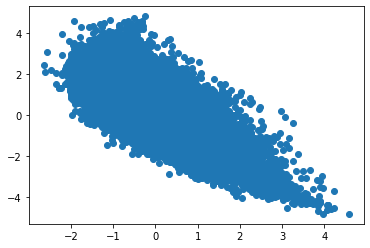

In [17]:
plt.scatter(train_standardised_dropna['sum_transactions_STD_t-0'], train_standardised_dropna['label1'])

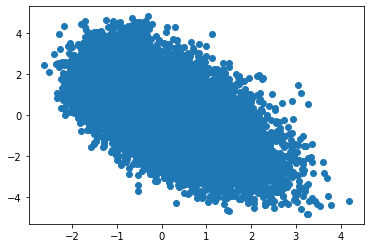

In [18]:
plt.scatter(train_standardised_dropna['number_of_customers_STD_t-0'], train_standardised_dropna['label1'])

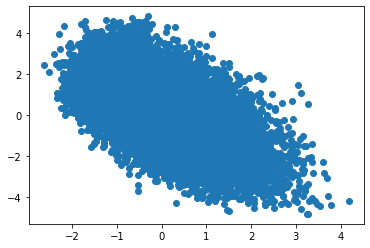

In [19]:
plt.scatter(train_standardised_dropna['distinct_customers_STD_t-0'], train_standardised_dropna['label1'])

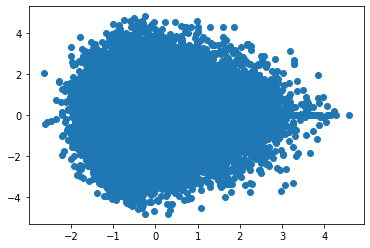

In [20]:
plt.scatter(train_standardised_dropna['sum_transactions_STD_t-1'], train_standardised_dropna['label1'])

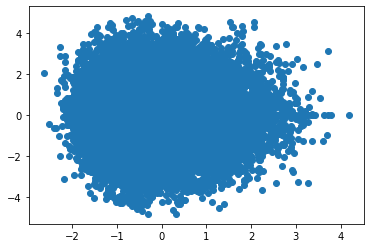

In [21]:
plt.scatter(train_standardised_dropna['number_of_customers_STD_t-1'], train_standardised_dropna['label1'])

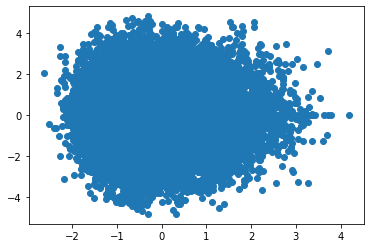

In [22]:
plt.scatter(train_standardised_dropna['distinct_customers_STD_t-1'], train_standardised_dropna['label1'])

# Models
### 1. Linear Regression

label1

In [31]:
from sklearn.linear_model import LinearRegression

In [32]:
LR = LinearRegression()
LR.fit(train_standardised_dropna[['sum_transactions_STD_t-0', 
    'number_of_customers_STD_t-0', 
    'distinct_customers_STD_t-0']], train_standardised_dropna['label1'])

LinearRegression()

In [33]:
predictions = LR.predict(train_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']])

pd.DataFrame({'predictions':predictions}).describe()

,predictions
count,45189.000000
mean,0.030275
std,0.805496
min,-4.795080
25%,-0.372863
50%,0.160314
75%,0.567405
max,2.582606


In [35]:
LR.score(train_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']], train_standardised_dropna['label1'])

0.5077145072399425

In [36]:
LR.score(val_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']], val_standardised_dropna['label1'])

-0.029867701607257713

In [37]:
LR.score(test_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']], test_standardised_dropna['label1'])

0.4726485719503615

label 2

In [54]:
LR1 = LinearRegression()
LR1.fit(train_standardised_dropna[['sum_transactions_STD_t-0', 
    'sum_transactions_STD_t-1',
    'sum_transactions_STD_t-2',
    'sum_transactions_STD_t-3',
    'sum_transactions_STD_t-4'
]], train_standardised_dropna['label2'])

LinearRegression()

In [55]:
predictions = LR1.predict(train_standardised_dropna[['sum_transactions_STD_t-0', 
    'sum_transactions_STD_t-1',
    'sum_transactions_STD_t-2',
    'sum_transactions_STD_t-3',
    'sum_transactions_STD_t-4']])

pd.DataFrame({'predictions':predictions}).describe()

,predictions
count,45189.000000
mean,-0.099107
std,0.037153
min,-0.273217
25%,-0.120962
50%,-0.095182
75%,-0.073319
max,0.025572


In [56]:
LR1.score(train_standardised_dropna[['sum_transactions_STD_t-0', 
    'sum_transactions_STD_t-1',
    'sum_transactions_STD_t-2',
    'sum_transactions_STD_t-3',
    'sum_transactions_STD_t-4']], train_standardised_dropna['label1'])

0.011563269723849245

In [57]:
LR1.score(val_standardised_dropna[['sum_transactions_STD_t-0', 
    'sum_transactions_STD_t-1',
    'sum_transactions_STD_t-2',
    'sum_transactions_STD_t-3',
    'sum_transactions_STD_t-4']], val_standardised_dropna['label1'])

-0.02826962757423246

In [58]:
LR1.score(test_standardised_dropna[['sum_transactions_STD_t-0', 
    'sum_transactions_STD_t-1',
    'sum_transactions_STD_t-2',
    'sum_transactions_STD_t-3',
    'sum_transactions_STD_t-4']], test_standardised_dropna['label1'])

-0.1424553662058512

### 2. XGBoost 

label 1

In [23]:
import xgboost

In [25]:
m1 = xgboost.XGBRegressor()
m1.fit(train_standardised_dropna[['sum_transactions_STD_t-0', 
    'number_of_customers_STD_t-0', 
    'distinct_customers_STD_t-0']], train_standardised_dropna['label1'])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [26]:
predictions = m1.predict(train_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']])

pd.DataFrame({'predictions':predictions}).describe()

,predictions
count,45189.000000
mean,0.030242
std,0.817589
min,-4.606647
25%,-0.379073
50%,0.121023
75%,0.555509
max,3.511868


In [27]:
m1.score(train_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']], train_standardised_dropna['label1'])

0.568289779909569

In [28]:
m1.score(val_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']], val_standardised_dropna['label1'])

-0.05864081019149925

In [29]:
m1.score(test_standardised_dropna[['sum_transactions_STD_t-0', 'number_of_customers_STD_t-0', 'distinct_customers_STD_t-0']], test_standardised_dropna['label1'])

0.45497041017788875

label 2

In [67]:
m = xgboost.XGBRegressor()

In [69]:
m.fit(train_standardised_dropna[['sum_transactions_STD_t-0', 
    'sum_transactions_STD_t-1',
    'sum_transactions_STD_t-2',
    'sum_transactions_STD_t-3',
    'sum_transactions_STD_t-4'
]], train_standardised_dropna['label2'])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [70]:
predictions = m.predict(train_standardised_dropna[['sum_transactions_STD_t-0', 
    'sum_transactions_STD_t-1',
    'sum_transactions_STD_t-2',
    'sum_transactions_STD_t-3',
    'sum_transactions_STD_t-4']])

pd.DataFrame({'predictions':predictions}).describe()

,predictions
count,45189.000000
mean,-0.099139
std,0.176811
min,-1.110840
25%,-0.172111
50%,-0.108059
75%,-0.046318
max,2.154304


In [71]:
m.score(train_standardised_dropna[['sum_transactions_STD_t-0', 
    'sum_transactions_STD_t-1',
    'sum_transactions_STD_t-2',
    'sum_transactions_STD_t-3',
    'sum_transactions_STD_t-4']], train_standardised_dropna['label1'])

0.1002040306861246

In [72]:
m.score(val_standardised_dropna[['sum_transactions_STD_t-0', 
    'sum_transactions_STD_t-1',
    'sum_transactions_STD_t-2',
    'sum_transactions_STD_t-3',
    'sum_transactions_STD_t-4']], val_standardised_dropna['label1'])

-0.041246267921657864

In [73]:
m.score(test_standardised_dropna[['sum_transactions_STD_t-0', 
    'sum_transactions_STD_t-1',
    'sum_transactions_STD_t-2',
    'sum_transactions_STD_t-3',
    'sum_transactions_STD_t-4']], test_standardised_dropna['label1'])

-0.08181911857022528

### 3. Random Forest Regression

label 1

In [46]:
from sklearn.ensemble import RandomForestRegressor

In [48]:
RFR = RandomForestRegressor()
RFR.fit(train_standardised_dropna.drop(['Year', 'Fortnight', 'merchant_abn', 'label1', 'label2'], axis=1), train_standardised_dropna['label1'])

RandomForestRegressor()

In [51]:
RFR.score(train_standardised_dropna.drop(['Year', 'Fortnight', 'merchant_abn', 'label1', 'label2'], axis=1), train_standardised_dropna['label1'])

0.9243438470999903

In [52]:
RFR.score(val_standardised_dropna.drop(['Year', 'Fortnight', 'merchant_abn', 'label1', 'label2'], axis=1), val_standardised_dropna['label1'])

-0.023818854614364504

In [53]:
RFR.score(test_standardised_dropna.drop(['Year', 'Fortnight', 'merchant_abn', 'label1', 'label2'], axis=1), test_standardised_dropna['label1'])

0.4418797938913085

label 2

In [60]:
RFR1 = RandomForestRegressor()
RFR1.fit(train_standardised_dropna[['sum_transactions_STD_t-0', 
    'sum_transactions_STD_t-1',
    'sum_transactions_STD_t-2',
    'sum_transactions_STD_t-3',
    'sum_transactions_STD_t-4'
]], train_standardised_dropna['label2'])

RandomForestRegressor()

In [61]:
predictions = RFR1.predict(train_standardised_dropna[['sum_transactions_STD_t-0', 
    'sum_transactions_STD_t-1',
    'sum_transactions_STD_t-2',
    'sum_transactions_STD_t-3',
    'sum_transactions_STD_t-4']])

pd.DataFrame({'predictions':predictions}).describe()

,predictions
count,45189.000000
mean,-0.091922
std,0.508397
min,-1.774896
25%,-0.435167
50%,-0.165097
75%,0.173046
max,2.790557


In [62]:
RFR1.score(train_standardised_dropna[['sum_transactions_STD_t-0', 
    'sum_transactions_STD_t-1',
    'sum_transactions_STD_t-2',
    'sum_transactions_STD_t-3',
    'sum_transactions_STD_t-4']], train_standardised_dropna['label1'])

0.4240184006942648

In [63]:
RFR1.score(val_standardised_dropna[['sum_transactions_STD_t-0', 
    'sum_transactions_STD_t-1',
    'sum_transactions_STD_t-2',
    'sum_transactions_STD_t-3',
    'sum_transactions_STD_t-4']], val_standardised_dropna['label1'])

-0.059513413633985435

In [64]:
RFR1.score(test_standardised_dropna[['sum_transactions_STD_t-0', 
    'sum_transactions_STD_t-1',
    'sum_transactions_STD_t-2',
    'sum_transactions_STD_t-3',
    'sum_transactions_STD_t-4']], test_standardised_dropna['label1'])

-0.21375774616903387